## 全体構成
- GAN学習コード

- エミュレータ

GAN学習コード
-

In [20]:
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt

ハイパーパラメータ

In [21]:
batch_size = 64
nz = 100         # 入力次元
img_size = 32    # 画像サイズ

# 時間がかかるのでGPU推奨
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

OUTPUT_DIR = "output_train_5"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device: cuda


データセット
-
""" 
my_totalのカラー画像（3ch）と、
my_rgb/R,G,Bの1ch画像を同時に返す
"""

In [22]:
class GanDataset(Dataset):
    def __init__ (self, color_dir="my_total", rgb_root="my_rgb", img_size=32):
        self.color_dir = color_dir
        self.rgb_root = rgb_root

        # カラー画像
        self.color_files = [
            f for f in os.listdir(color_dir)
            if f.lower().endswith(".png")
        ]
        self.color_files.sort()

        # Rフォルダ側のファイル名
        self.rgb_files = [
            f for f in os.listdir(os.path.join(rgb_root,"R"))
            if f.lower().endswith(".png")
        ]
        self.rgb_files.sort()

        self.length = min(len(self.color_files),len(self.rgb_files))

        print("len(color_files) =", len(self.color_files))
        print("len(rgb_files) =", len(self.rgb_files))
        print("=> dataset length =", self.length)
        if self.length == 0:
            raise RuntimeError("No data")

        
        self.t_color = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5)) # [-1,1]
        ])

        self.t_gray = transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,)) # [-1,1]
        ])


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # カラー側：idx番目のファイル
        color_fname = self.color_files[idx]
        c_path = os.path.join(self.color_dir, color_fname)
        c_img = Image.open(c_path).convert("RGB")
        # t_colorを用いてテンソル化
        color = self.t_color(c_img) # [3,H,W]

        # R/G/B側　
        rgb_fname = self.rgb_files[idx]
        r_path = os.path.join(self.rgb_root, "R", rgb_fname)
        g_path = os.path.join(self.rgb_root, "G", rgb_fname)
        b_path = os.path.join(self.rgb_root, "B", rgb_fname)

        r_img = Image.open(r_path).convert("L")
        g_img = Image.open(g_path).convert("L")
        b_img = Image.open(b_path).convert("L")

        r = self.t_gray(r_img) # [1,H,W]
        g = self.t_gray(g_img)
        b = self.t_gray(b_img)

        return color, r, g, b, rgb_fname

dataset = GanDataset("my_total", "my_rgb", img_size=img_size)
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,drop_last=True)




len(color_files) = 275
len(rgb_files) = 275
=> dataset length = 275


datasetの確認用（学習には関係ない）

Color batch shape: torch.Size([64, 3, 32, 32])
R channel shape:   torch.Size([64, 1, 32, 32])
値の範囲 (Color): -1.00 ～ 1.00
最初のファイル名: 0062.png


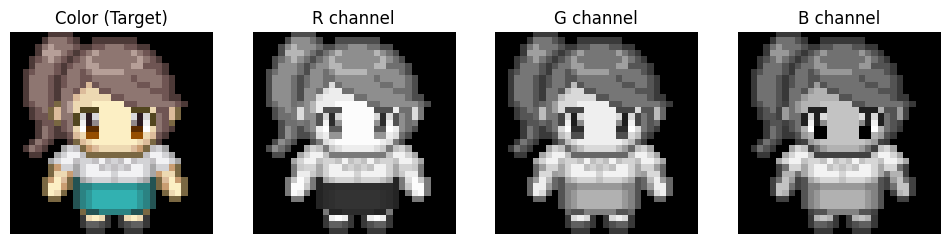

In [23]:
# 1バッチ分だけデータを取り出す
images, rs, gs, bs, fnames = next(iter(dataloader))

print(f"Color batch shape: {images.shape}") # [batch_size, 3, 32, 32]
print(f"R channel shape:   {rs.shape}")     # [batch_size, 1, 32, 32]
print(f"値の範囲 (Color): {images.min():.2f} ～ {images.max():.2f}") 
print(f"最初のファイル名: {fnames[0]}")

import matplotlib.pyplot as plt
import numpy as np

def show_data(color_tensor, r_tensor, g_tensor, b_tensor):
    # [-1, 1] を [0, 1] に戻す
    def denormalize(t):
        return (t * 0.5 + 0.5).clamp(0, 1)

    # numpy形式に変換 (C, H, W) -> (H, W, C)
    img = denormalize(color_tensor).permute(1, 2, 0).numpy()
    r = denormalize(r_tensor).squeeze().numpy() # [1, 32, 32] -> [32, 32]
    g = denormalize(g_tensor).squeeze().numpy()
    b = denormalize(b_tensor).squeeze().numpy()

    # 表示
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(img)
    axes[0].set_title("Color (Target)")
    axes[1].imshow(r, cmap='gray')
    axes[1].set_title("R channel")
    axes[2].imshow(g, cmap='gray')
    axes[2].set_title("G channel")
    axes[3].imshow(b, cmap='gray')
    axes[3].set_title("B channel")
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# バッチの中の最初の1枚を表示
show_data(images[0], rs[0], gs[0], bs[0])


　ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

Generatorの定義
-
入力　z 100次元　[B,nz]

出力　生成画像   [B,1,32,32]  in [-1,1]

nn.ConvTranspose2d(入力、出力、カーネル、stride, padding, bias)

In [24]:

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=128):
        super().__init__()
        self.nz = nz

        self.net = nn.Sequential(
            # [B,nz,1,1] → [B,ngf*4,4,4]
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.ReLU(True),

            # [B,ngf*4,4,4] → [B,ngf*2,8,8]
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.ReLU(True),

            # [B,ngf*2,8,8] → [B,ngf,16,16]
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.ReLU(True),

            # [B,ngf,16,16] -> [B,1,32,32]
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # [-1,1]
        )

   
    def forward(self,z):
         # [B,100] →　[B,100,1,1]
        if z.dim() == 2:
            z = z.view(z.size(0),z.size(1),1,1)
        return self.net(z)

Discriminatorの定義
-
①グレースケール用：アバターの形を学習させる目的

入力　R/G/Bのグレースケール画像

出力　[B,1]の値。（正：本物と判断　０：本物と偽物の区別がつかない　負：偽物と判断）

本来は出力をsigmoidなどで0～1の値に収めるが、nn.BCEWithLogitsLossを用いるため省略


In [25]:
class DiscriminatorGray(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            # [B,1,32,32] →　[B,ndf,16,16]
            nn.Conv2d(1,ndf,4,2,1),
            nn.LeakyReLU(0.2,inplace=True),

            # [B,ndf,16,16] →　[B,ndf*2,8,8]
            nn.Conv2d(ndf,ndf*2,4,2,1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),

            #[B,ndf*2,8,8] →　[B,ndf*4,4,4]
            nn.Conv2d(ndf*2, ndf*4,4,2,1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Flatten(), #[B,ndf*4*4*4]
            nn.Linear(ndf*4*4*4,1) #[B,1]
        )

    def forward(self,x):
        return self.net(x) # [B,1]
    

②カラー用：色の付け方を学習させる目的。

入力　カラー画像3ch
出力　[B,1]の本物/偽物判別スコア



※本来は②だけでも良かったかもしれないが精度がでなかった（やり方次第で変わるかもしれませんが、、、）ので、①のDiscriminatorを追加している。

②だけだと、形も色も判別しなくてはいけない。

①で形を、②で色味を判断することで、仕事を分担できるのではという発想



In [26]:
class DiscriminatorColor(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            # [B,3,32,32]　→　[B,ndf,16,16]
            nn.Conv2d(3,ndf,4,2,1),
            nn.LeakyReLU(0.2, inplace=True),

            # [B,ndf,16,16] →　[B,ndf*2,8,8]
            nn.Conv2d(ndf,ndf*2,4,2,1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),

            #[B,ndf*2,8,8] →　[B,ndf*4,4,4]
            nn.Conv2d(ndf*2, ndf*4,4,2,1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Flatten(), #[B,ndf*4*4*4]
            nn.Linear(ndf*4*4*4,1) #[B,1]
        )

    def forward(self,x):
        return self.net(x) # [B,1]
        

その他関数
- 
weight_init:重み初期化、make_noise：入力作成、denorm：[-1,1]→[0,1]

In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        if hasattr(m,"weight") and m.weight is not None:
            nn.init.normal_(m.weight.data,0.0,0.02)
        if hasattr(m,"bias") and m.bias is not None:
            nn.init.constant_(m.bias.data,0.0)
    elif classname.find("Linear") != -1:
        if hasattr(m,"weight") and m.weight is not None:
            nn.init.normal_(m.weight.data,0.0,0.02)
        if hasattr(m,"bias") and m.bias is not None:
            nn.init.constant_(m.bias.data,0.0)


# def make_noise(batch, nz, device):
#     return torch.randn(batch, nz, device=device)

def make_noise(batch, nz, device):
    z = torch.randn(batch, nz, device=device)
    return torch.tanh(z)

def denorm(x):
    return (x + 1.0)/2.0

保存用関数
-
save_eval 　：　学習中の画像を3ch、RGBに分けて表示

plot_losses ： 損失関数の保存

In [28]:
def save_eval(R,G,B,color,outdir,prefix="eval"):
    os.makedirs(outdir, exist_ok=True)

    # [-1,1]→[0,1]
    Rv = denorm(R)
    Gv = denorm(G)
    Bv = denorm(B)
    Cv = denorm(color)

    # repeatは各次元を何倍にするかを指定。1ch→3ch
    Rv3 = Rv.repeat(1,3,1,1)
    Gv3 = Gv.repeat(1,3,1,1)
    Bv3 = Bv.repeat(1,3,1,1)

    grid = utils.make_grid(
        torch.cat([Rv3, Gv3, Bv3, Cv], dim=0),
        nrow=4
    )
    plt.figure(figsize=(8,2))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("R,G,B,RGB")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{prefix}_grid.png"),dpi=150, bbox_inches="tight")
    plt.close()


def plot_losses(Dg_hist, Dc_hist, G_hist, outdir=OUTPUT_DIR,fname="loss_curve.png"):
    os.makedirs(outdir,exist_ok=True)
    epochs = range(1,len(Dg_hist)+1)

    plt.figure()
    plt.plot(epochs, Dg_hist, label="D gray loss")
    plt.plot(epochs, Dc_hist, label="D color loss")
    plt.plot(epochs, G_hist,  label="G loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(outdir, fname)
    plt.savefig(save_path, bbox_inches="tight",dpi=150)
    plt.close()
    print("Loss曲線を保存しました：",save_path)


Train
-


In [29]:
def train_gan(netG,netD_gray,netD_color,v1,v2,dataloader,n_epochs=100,lrG=1e-4,lrD=1e-6,lambda_color=1.0):
    netG.to(device)
    netD_gray.to(device)
    netD_color.to(device)

    netG.train()
    netD_gray.train()
    netD_color.train()

    criterion = nn.BCEWithLogitsLoss()

    optG = optim.Adam(netG.parameters(),lr=lrG,betas=(0.5,0.999))
    optDg = optim.Adam(netD_gray.parameters(),lr=lrD, betas=(0.5,0.999))
    optDc = optim.Adam(netD_color.parameters(),lr=lrD,betas=(0.5,0.999))

    Dg_history = []
    Dc_history = []
    G_history = []

    for epoch in range(1, n_epochs + 1):
        lossDg_sum = 0.0
        lossDc_sum = 0.0
        lossG_sum  = 0.0
        n_batches = 0

        for color_real, r_real, g_real, b_real, _ in dataloader:
            color_real = color_real.to(device)
            r_real = r_real.to(device)
            g_real = g_real.to(device)
            b_real = b_real.to(device)

            B = color_real.size(0)

            #ラベルスムージング：real=0.9、fake=0.0
            real_labels = torch.full((B,1),0.9,device=device)
            fake_labels = torch.zeros(B,1,device=device)


            # =====================================================
            # Discriminator(gray)の更新
            # =====================================================

            optDg.zero_grad()

            # R,G,Bのグレー画像をcatで結合
            x_real_gray = torch.cat([r_real,g_real,b_real],dim=0)
            lbl_real_gray = torch.full((3*B,1),0.9,device=device)

            #fake:G(z),G(z+v1),G(z+v2)
            z = make_noise(B, nz, device)
            z_r = z
            z_g = z + v1
            z_b = z + v2

            with torch.no_grad():
                r_fake = netG(z_r)
                g_fake = netG(z_g)
                b_fake = netG(z_b)
            
            x_fake_gray = torch.cat([r_fake, g_fake, b_fake], dim=0)
            lbl_fake_gray = torch.zeros(3*B,1,device=device) # fake=0

            out_real_gray = netD_gray(x_real_gray)
            out_fake_gray = netD_gray(x_fake_gray)

            lossDg_real = criterion(out_real_gray, lbl_real_gray)
            lossDg_fake = criterion(out_fake_gray, lbl_fake_gray)
            lossDg = lossDg_real + lossDg_fake
            lossDg.backward() #　勾配計算
            optDg.step() #　更新


            # =====================================================
            # Discriminator(color)の更新
            # =====================================================
            optDc.zero_grad()

            out_real_c = netD_color(color_real)

            with torch.no_grad():
                r_fake = netG(z_r)
                g_fake = netG(z_g)
                b_fake = netG(z_b)
                color_fake = torch.cat([r_fake, g_fake, b_fake], dim=1)
            
            out_fake_c = netD_color(color_fake)

            lossDc_real = criterion(out_real_c, real_labels)
            lossDc_fake = criterion(out_fake_c, fake_labels)
            lossDc = lossDc_real + lossDc_fake
            lossDc.backward()
            optDc.step()


            # =====================================================
            # Generatorの更新
            # =====================================================
            optG.zero_grad()

            z = make_noise(B,nz,device)
            z_r = z
            z_g = z + v1
            z_b = z + v2

            r_fake = netG(z_r)
            g_fake = netG(z_g)
            b_fake = netG(z_b)
            color_fake = torch.cat([r_fake, g_fake, b_fake], dim=1)

            x_fake_gray = torch.cat([r_fake, g_fake, b_fake], dim=0) # [3B,1,H,W]
            lbl_gray_forG = torch.ones(3*B,1,device=device) # Gの出力を1と判別させたい

            out_fake_gray_forG = netD_gray(x_fake_gray)
            lossG_gray = criterion(out_fake_gray_forG, lbl_gray_forG)

            out_fake_c_forG = netD_color(color_fake)
            lossG_color = criterion(out_fake_c_forG, real_labels)

            lossG = lossG_gray + lambda_color * lossG_color
            lossG.backward()
            optG.step()

            lossDg_sum += lossDg.item()
            lossDc_sum += lossDc.item()
            lossG_sum += lossG.item()
            n_batches += 1
        
        avg_Dg = lossDg_sum / n_batches
        avg_Dc = lossDc_sum / n_batches
        avg_G  = lossG_sum  / n_batches

        Dg_history.append(avg_Dg)
        Dc_history.append(avg_Dc)
        G_history.append(avg_G)

        print(f"[Epoch {epoch:03d}]"
              f"Dg:{avg_Dg:.4f},"
              f"Dc:{avg_Dc:.4f},"
              f"G:{avg_G:.4f}")
        
        if epoch % 1000 == 0:
            with torch.no_grad():
                z_eval = make_noise(1,nz,device)
                R = netG(z_eval)
                G_ = netG(z_eval + v1)
                B_ = netG(z_eval + v2)
                color_eval = torch.cat([R,G_,B_], dim=1)
                save_eval(R, G_, B_, color_eval, OUTPUT_DIR, prefix=f"epoch{epoch:03d}")

    return Dg_history, Dc_history, G_history
 

メイン
-

In [30]:
if __name__ == "__main__":

    netG = Generator(nz=nz, ngf=128)
    netD_gray = DiscriminatorGray(ndf=64)
    netD_color = DiscriminatorColor(ndf=64)

    #重み初期化
    netG.apply(weights_init)
    netD_gray.apply(weights_init)
    netD_color.apply(weights_init)

    #固定ベクトルv1、v2をランダムに生成
    v1 = torch.randn(nz,device=device)
    v2 = torch.randn(nz,device=device)

    n_epochs = 10000

    Dg_hist, Dc_hist, G_hist = train_gan(netG,netD_gray,netD_color,v1,v2,dataloader,n_epochs=n_epochs,lrG=1e-4,lrD=1e-6,lambda_color=1.0,)

    plot_losses(Dg_hist,Dc_hist,G_hist,outdir=OUTPUT_DIR,fname="loss_curve.png")

    # float32の学習済みGeneratorを保存
    float_weight_path = os.path.join(OUTPUT_DIR,"netG_float32.pth")
    torch.save(netG.state_dict(),float_weight_path)
    torch.save({"v1":v1,"v2":v2},os.path.join(OUTPUT_DIR,"v1v2.pth"))
    print("float32 Generatorを保存完了：",float_weight_path)

[Epoch 001]Dg:3.8389,Dc:3.4427,G:0.9256
[Epoch 002]Dg:6.0639,Dc:3.1680,G:0.4248
[Epoch 003]Dg:6.0755,Dc:3.2781,G:0.3734
[Epoch 004]Dg:6.1087,Dc:3.2145,G:0.3603
[Epoch 005]Dg:6.0973,Dc:3.1825,G:0.3544
[Epoch 006]Dg:6.1348,Dc:3.1872,G:0.3488
[Epoch 007]Dg:6.2168,Dc:3.2088,G:0.3540
[Epoch 008]Dg:6.2792,Dc:3.0224,G:0.3439
[Epoch 009]Dg:6.2837,Dc:3.0486,G:0.3416
[Epoch 010]Dg:6.3570,Dc:3.1267,G:0.3462
[Epoch 011]Dg:6.3742,Dc:2.9749,G:0.3413
[Epoch 012]Dg:6.4472,Dc:3.0422,G:0.3425
[Epoch 013]Dg:6.4576,Dc:3.0173,G:0.3397
[Epoch 014]Dg:6.4438,Dc:2.9818,G:0.3361
[Epoch 015]Dg:6.4831,Dc:2.9110,G:0.3389
[Epoch 016]Dg:6.4636,Dc:3.0401,G:0.3426
[Epoch 017]Dg:6.4868,Dc:2.9623,G:0.3352
[Epoch 018]Dg:6.5179,Dc:2.8937,G:0.3359
[Epoch 019]Dg:6.5408,Dc:2.9720,G:0.3365
[Epoch 020]Dg:6.5539,Dc:2.9004,G:0.3366
[Epoch 021]Dg:6.5611,Dc:2.8608,G:0.3353
[Epoch 022]Dg:6.5675,Dc:2.8146,G:0.3343
[Epoch 023]Dg:6.5608,Dc:2.8999,G:0.3352
[Epoch 024]Dg:6.5811,Dc:2.8518,G:0.3329
[Epoch 025]Dg:6.6213,Dc:2.8042,G:0.3333


評価用関数
-


In [31]:
# ランダム入力から生成
def eval_random(netG, v1, v2, outdir=OUTPUT_DIR, prefix="final"):
    netG.to(device)
    netG.eval()
    with torch.no_grad():
        z = make_noise(1, nz, device)
        R = netG(z)
        G = netG(z + v1)
        B = netG(z + v2)
        color = torch.cat([R,G,B],dim=1)
        save_eval(R,G,B,color, outdir, prefix)

    print("評価画像を保存しました：",outdir)

# 30種類のランダム入力
def eval_random_30_color(netG, v1, v2, outdir=OUTPUT_DIR, prefix="final30_color",n_samples=30):
    netG.to(device)
    netG.eval()
    os.makedirs(outdir, exist_ok=True)

    with torch.no_grad():
        z = make_noise(n_samples,nz,device)

        R = netG(z)
        G = netG(z+v1)
        B = netG(z+v2)
        RGB = torch.cat([R,G,B],dim=1)

        Cv = denorm(RGB)
        grid = utils.make_grid(Cv, nrow=6)

        plt.figure(figsize=(8,6))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.title(f"RGB color images ({n_samples} samples)")
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"{prefix}_grid.png"),dpi=150, bbox_inches="tight")
        plt.close()

    print(f"{n_samples} サンプルカラー画像を保存しました：{outdir}")


In [32]:
eval_random(netG, v1, v2, outdir=OUTPUT_DIR, prefix="final_float")
eval_random_30_color(netG, v1, v2, outdir=OUTPUT_DIR, prefix="final30_float")

評価画像を保存しました： output_train_5
30 サンプルカラー画像を保存しました：output_train_5


浮動小数点
-
Q1.7 符号部1bit、少数部7bit

In [33]:
import json

Q_FRAC = 7
Q_SCALE = 1 << Q_FRAC #128

def float_to_int8_list(x: torch.Tensor) -> torch.Tensor:
    xq = torch.round(x * Q_SCALE)
    xq = torch.clamp(xq, -128, 127)
    xq = xq.to(torch.int8)
    return xq.cpu().tolist()

In [34]:
# テスト

x = torch.tensor([
    -1.0,
    -0.5,
    -0.25,
     0.0,
     0.25,
     0.5,
     0.992,
     1.0
])

q_list = float_to_int8_list(x)

print("input float:", x.tolist())
print("Q1.7 int8 :", q_list)
print("back to float:", [v / Q_SCALE for v in q_list])


input float: [-1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 0.9919999837875366, 1.0]
Q1.7 int8 : [-128, -64, -32, 0, 32, 64, 127, 127]
back to float: [-1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 0.9921875, 0.9921875]


Generatorのパラメータをint8で保存

In [35]:
def export_generator(netG, OUTPUT_DIR,folder_name="G_q17_list"):
    save_dir = os.path.join(OUTPUT_DIR, folder_name)
    os.makedirs(save_dir, exist_ok=True)

    meta = {}

    conv_idx = 0
    for layer in netG.net:
        if isinstance(layer, torch.nn.ConvTranspose2d):
            name = f"net{conv_idx}"
            conv_idx += 1

            w = layer.weight.detach()
            w_list = float_to_int8_list(w)

            # JSON保存
            json_path = os.path.join(save_dir, f"{name}_weight_q17_list.json")
            with open(json_path, "w", encoding="utf-8") as f:
                json.dump(w_list, f)

            # TXT保存
            txt_path = os.path.join(save_dir, f"{name}_weight_q17_list.txt")
            with open(txt_path, "w", encoding="utf-8") as f:
                f.write(f"{name} weight (Q1.7 int8)\n")
                f.write(f"shape = [out_ch][in_ch][4][4]\n")
                f.write("value = int8 (real=value/128)\n\n")

                # w_list [out_ch][in_ch][kH][kW]
                for out_ch_id, oc_block in enumerate(w_list):
                    f.write(f"=== out_ch {out_ch_id} ===\n")
                    for in_ch_id, kernel in enumerate(oc_block):
                        f.write(f" -- in_ch {in_ch_id} --\n")
                        for row in kernel:
                            f.write("".join(f"{v:4d}" for v in row)+"\n")
                        f.write("\n")

            meta[name] = {"shape":[len(w_list),len(w_list[0]),4,4],"json":os.path.basename(json_path),"txt":os.path.basename(txt_path)}
    # メタ情報
    meta_path = os.path.join(save_dir, "meta.json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)
    
    return save_dir

            

In [36]:
# テスト

save_dir = export_generator(netG, OUTPUT_DIR=OUTPUT_DIR, folder_name="G_q17_list")

print("saved to:",save_dir)

saved to: output_train_5\G_q17_list


int8のパラメータをバイナリで保存

In [37]:
# def json_to_binary(save_dir:str, out_folder_name:str = "bin"):
#     meta_path = os.path.join(save_dir, "meta.json")
#     with open(meta_path, "r", encoding="utf-8") as f:
#         meta = json.load(f)
    
#     out_dir = os.path.join(save_dir, out_folder_name)
#     os.makedirs(out_dir,exist_ok=True)

#     meta_bin = {}

#     for name, info in meta.items():
#         json_file = os.path.join(save_dir, info["json"])
#         shape = info["shape"]

#         with open(json_file, "r", encoding="utf-8") as f:
#             w_list = json.load(f)

#         arr = np.array(w_list, dtype=np.int8)

#         # raw bin
#         bin_path = os.path.join(out_dir, f"{name}_weight_q17_raw.bin")
#         arr.tofile(bin_path)

#         # full txt
#         txt_path = os.path.join(out_dir, f"{name}_weight_q17_full.txt")
#         with open(txt_path, "w", encoding = "utf-8") as ftxt:
#             ftxt.write(f"{name} weight (Q1.7 int8)\n")
#             ftxt.write("shape = [out_ch][in_ch][4][4]\n")
#             ftxt.write("value = int8 (real = value /128)\n\n")

#             out_ch, in_ch, kH, kW = arr.shape
#             for oc in range(out_ch):
#                 ftxt.write(f"=== out_ch {oc} ===\n")
#                 for ic in range(in_ch):
#                     ftxt.write(f"-- in_ch {ic} --\n")
#                     kernel = arr[oc, ic]
#                     for r in range(kH):
#                         row = "".join(f"{int(v):4d}"for v in kernel[r])
#                         ftxt.write(row+"\n")
#                     ftxt.write("\n")

#         meta_bin[name] = {"shape":shape, "dtype":"int8", "order":"C", "raw_bin":os.path.basename(bin_path),"full_txt":os.path.basename(txt_path),}
    
#     with open(os.path.join(out_dir, "meta_bin.json"),"w",encoding="utf-8")as f:
#         json.dump(meta_bin, f, indent=2)

#     return out_dir

In [ ]:
# save_dir = export_generator(netG, OUTPUT_DIR, folder_name="G_q17_list")
# bin_dir = json_to_binary(save_dir,out_folder_name="bin")
#print("bin save to :",bin_dir)

NameError: name 'bin_dir' is not defined